We consider 2D Complex Ginzburg Landau Equation (CGLE) with additive noise.

The observation operator only observes the absolute value. 

We employ an ENKF, with inflation and relaxation. 

In [19]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.CGLE import *
from filters import resamplers
from filters.filter_2D import EnsembleKalmanFilter_2D
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

Initialisation of a twin experiment. 

We consider the standard CGLE:
$$
\partial_t A = A + (1 + i \alpha) \nabla^2 A - (1 + i \beta) |A|^2 A,
$$
where $A(x,t) \in \mathbb{C}$, and $\alpha, \beta \in \mathbb{R}$ control the dispersion and nonlinearity. 
We consider the stochastically forced CGLE: 
$$
d_t A = \left( A + (1 + i \alpha) \nabla^2 A - (1 + i \beta) |A|^2 A \right) dt + f_i \circ dW^i.
$$

We generate a signal with $E=1$, from which we noisily observe $y$. we consider a nonlinear observation operator projecting to a lower dimensional space as follows
$$
y = h(A) + \epsilon N(0,\mathbb{I}_{o\times o}\sigma)
$$
where the nonlinear operator is defined as $h(A) = |A|$


We also generate an ensemble of size $E=32$, used to track the signal through the use of the EnsembleKalmanFilter_2D class. 

In [20]:
signal_params = ConfigDict(CGLE_params)
ensemble_params = ConfigDict(CGLE_params)
signal_params.update(beta=.5,E=1,S=3,noise_magnitude = 0.001,stochastic_advection_basis='sin_sin')
ensemble_params.update(beta=0.5,E=32,S=3,noise_magnitude = 0.001,stochastic_advection_basis='sin_sin')
key = jax.random.PRNGKey(0)

Now we specify the models, by calling the class.

In [21]:
signal_model = CGLE_SETD_KT_CM_JAX(signal_params)
ensemble_model = CGLE_SETD_KT_CM_JAX(ensemble_params)

initial_signal = initial_condition(signal_model.xx,signal_model.yy,signal_params.E,signal_params.initial_condition)#initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.xx, ensemble_model.yy, ensemble_params.E, ensemble_params.initial_condition)

print(ensemble_model.params,ensemble_model.params.nt)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

E: 32
Forcing_basis_name: sin_sin
L: 100.0
Nt: 640
S: 3
alpha: 0.0
beta: 0.5
dt: 0.1
dx: 0.78125
equation_name: Complex Ginzburg-Landau
initial_condition: chebfun
method: Dealiased_SETDRK4_forced
noise_magnitude: 0.001
nt: 640
nx: 128
stochastic_advection_basis: sin_sin
tmax: 64.0
xmax: 50.0
xmin: -50.0
 640
multinomial, systematic, no_resampling, none, default


In [22]:
observation_spatial_frequency = int(64)
observation_noise = 0.025
number_of_observations_time = int(ensemble_model.params.nt/1)# every timestep
# Observe points every 8th grid cell in both directions, 1/64.
observation_locations = [(i, j) for i in range(0, 128, 8) for j in range(0, 128, 8)]

observation_temporal_frequency = int(ensemble_model.params.nt / number_of_observations_time)
print(f"Observation temporal frequency: {observation_temporal_frequency}")
print(f"Observation spatial locations:{observation_locations}")

enkf = EnsembleKalmanFilter_2D(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model, # enkf inherits from the ensemble model class, 
    signal_model = signal_model, # enkf inherits from the signal model class,
    sigma = observation_noise,
    observation_locations = observation_locations,
    relaxation_factor = 0.01,# weights between forecast and analysis. # 1=full analysis(da), 0=no analysis(only forecast)
    inflation_factor = 1.0,# highly sensitive manner of introducing spread into the ensemble #1.0=no inflation, >1.0=inflation
)
print(jnp.array(observation_locations).shape)

Observation temporal frequency: 1
Observation spatial locations:[(0, 0), (0, 8), (0, 16), (0, 24), (0, 32), (0, 40), (0, 48), (0, 56), (0, 64), (0, 72), (0, 80), (0, 88), (0, 96), (0, 104), (0, 112), (0, 120), (8, 0), (8, 8), (8, 16), (8, 24), (8, 32), (8, 40), (8, 48), (8, 56), (8, 64), (8, 72), (8, 80), (8, 88), (8, 96), (8, 104), (8, 112), (8, 120), (16, 0), (16, 8), (16, 16), (16, 24), (16, 32), (16, 40), (16, 48), (16, 56), (16, 64), (16, 72), (16, 80), (16, 88), (16, 96), (16, 104), (16, 112), (16, 120), (24, 0), (24, 8), (24, 16), (24, 24), (24, 32), (24, 40), (24, 48), (24, 56), (24, 64), (24, 72), (24, 80), (24, 88), (24, 96), (24, 104), (24, 112), (24, 120), (32, 0), (32, 8), (32, 16), (32, 24), (32, 32), (32, 40), (32, 48), (32, 56), (32, 64), (32, 72), (32, 80), (32, 88), (32, 96), (32, 104), (32, 112), (32, 120), (40, 0), (40, 8), (40, 16), (40, 24), (40, 32), (40, 40), (40, 48), (40, 56), (40, 64), (40, 72), (40, 80), (40, 88), (40, 96), (40, 104), (40, 112), (40, 120), (

To run the filter with all outputs, the input arrays need to have 3 dimensions.
They are (time, n_particles, space).

In [23]:
da_steps = number_of_observations_time #print(initial_ensemble.shape, initial_signal.shape, da_steps)
initial_ensemble = initial_ensemble[None, ...] # adding the time dimension
initial_signal = initial_signal[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX
final, all = enkf.run(initial_ensemble, initial_signal, da_steps ,key) # the final input is scan length
final_noda, all_noda = enkf.run_no_da(initial_ensemble, initial_signal, da_steps ,key) # the final input is scan length

In [24]:
print("final shapes:")
for i, arr in enumerate(final):
    print(f"final[{i}]:", arr.shape)

print("\nall shapes:")
for i, arr in enumerate(all):
    print(f"all[{i}]:", arr.shape)

final shapes:
final[0]: (1, 32, 128, 128)
final[1]: (1, 1, 128, 128)
final[2]: (2,)

all shapes:
all[0]: (640, 1, 32, 128, 128)
all[1]: (640, 1, 1, 128, 128)
all[2]: (640, 256)


In [25]:
print("\nFinal ensemble shape:", final)# force the computation of the model.CGLE 32x640x128x128 # 1min
print("\nFinal ensemble shape:", final_noda)# force the computation of the model.CGLE 32x640x128x128 # 1min


Final ensemble shape: (Array([[[[ 0.28029762+0.95694856j,  0.27350157+0.95818509j,
           0.26945416+0.95804088j, ...,  0.31686886+0.94551917j,
           0.30216918+0.95058649j,  0.2898644 +0.95441112j],
         [ 0.27349604+0.95818705j,  0.25261579+0.96313966j,
           0.23282083+0.96666939j, ...,  0.34603444+0.93440252j,
           0.32009386+0.94390164j,  0.29587911+0.9518077j ],
         [ 0.26944356+0.95804448j,  0.23281687+0.96667055j,
           0.19459483+0.97326282j, ...,  0.37871233+0.92034093j,
           0.34179457+0.93498979j,  0.30547384+0.94751591j],
         ...,
         [ 0.31689197+0.94550793j,  0.34606853+0.93438572j,
           0.37875993+0.92031635j, ...,  0.24800468+0.96610101j,
           0.26820322+0.96095894j,  0.2910355 +0.9542216j ],
         [ 0.30218165+0.95058068j,  0.32011473+0.94389221j,
           0.34182548+0.93497561j, ...,  0.26819512+0.96096268j,
           0.27660416+0.95881486j,  0.28778327+0.95544999j],
         [ 0.28987004+0.95440871

Put in the initial condition.

In [26]:
print(initial_ensemble.shape, initial_signal.shape)
answer = jnp.concatenate([initial_ensemble[jnp.newaxis,...],all[0]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member
print("answer shape:", answer.shape)
signal_answer = jnp.concatenate([initial_signal[jnp.newaxis,...],all[1]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member
print(signal_answer.shape,answer.shape)
noda_answer = jnp.concatenate([initial_ensemble[jnp.newaxis,...],all_noda[0]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member

(1, 32, 128, 128) (1, 1, 128, 128)
answer shape: (641, 32, 128, 128)
(641, 1, 128, 128) (641, 32, 128, 128)


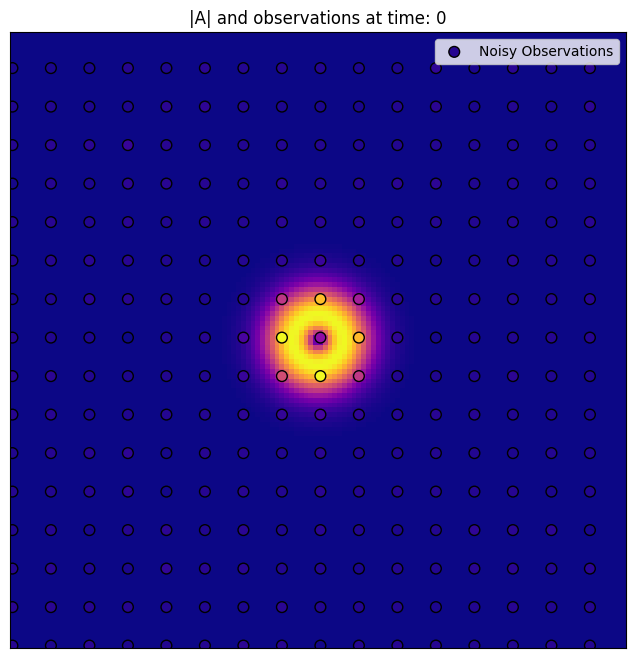

<Figure size 640x480 with 0 Axes>

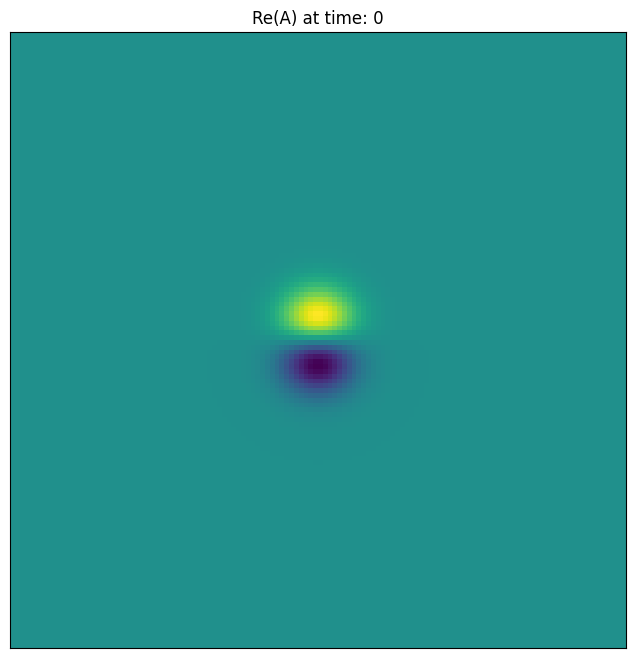

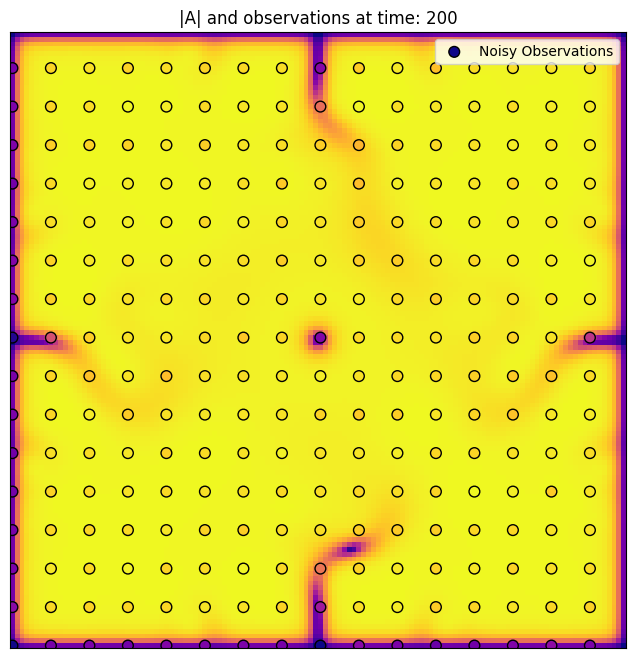

<Figure size 640x480 with 0 Axes>

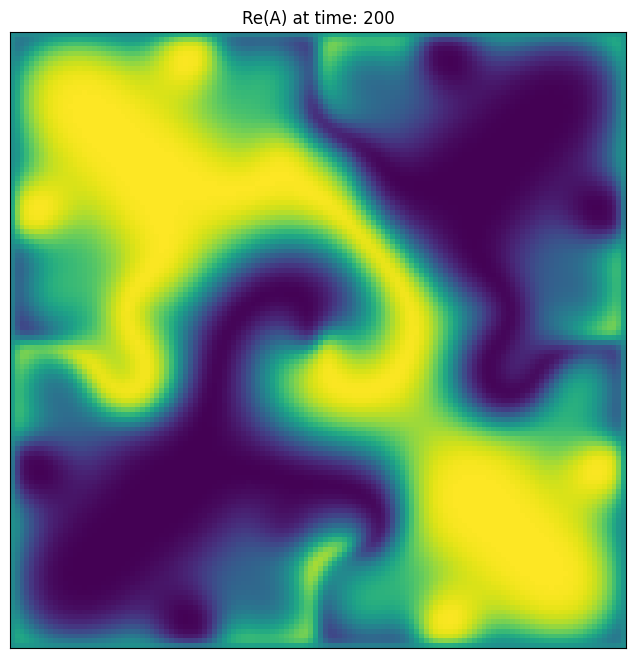

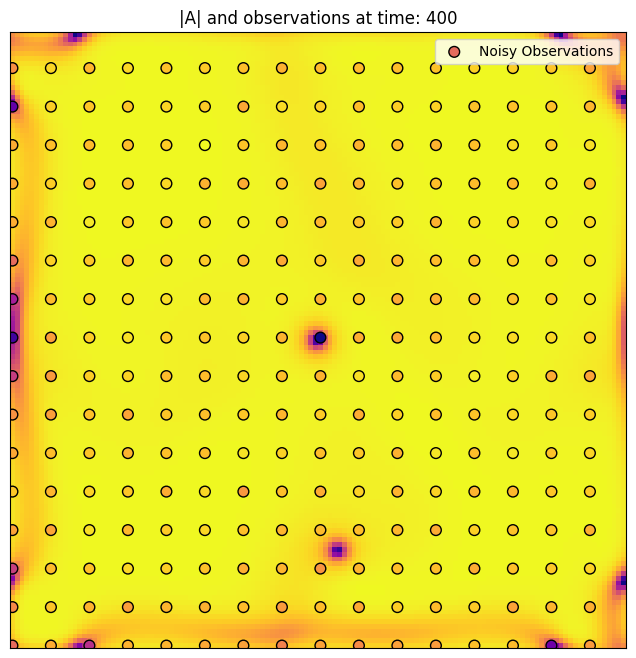

<Figure size 640x480 with 0 Axes>

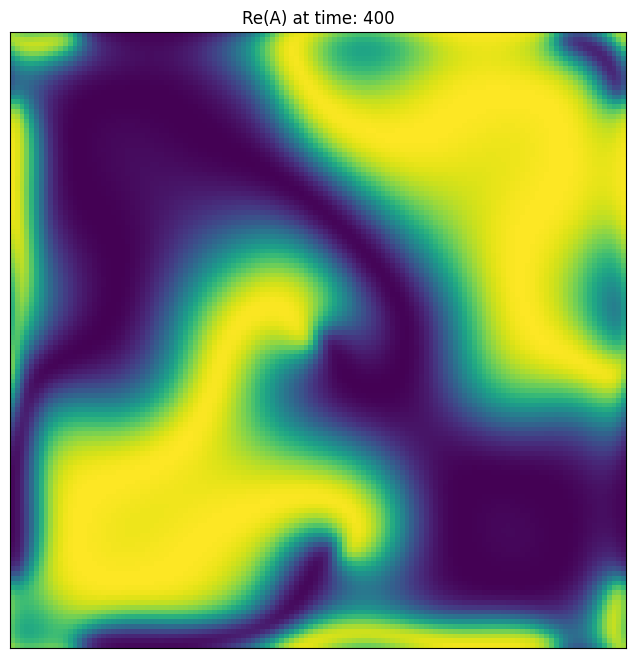

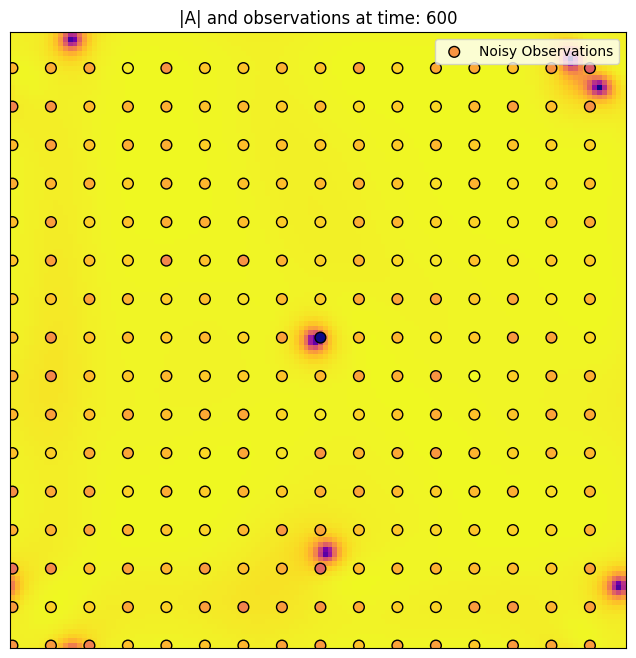

<Figure size 640x480 with 0 Axes>

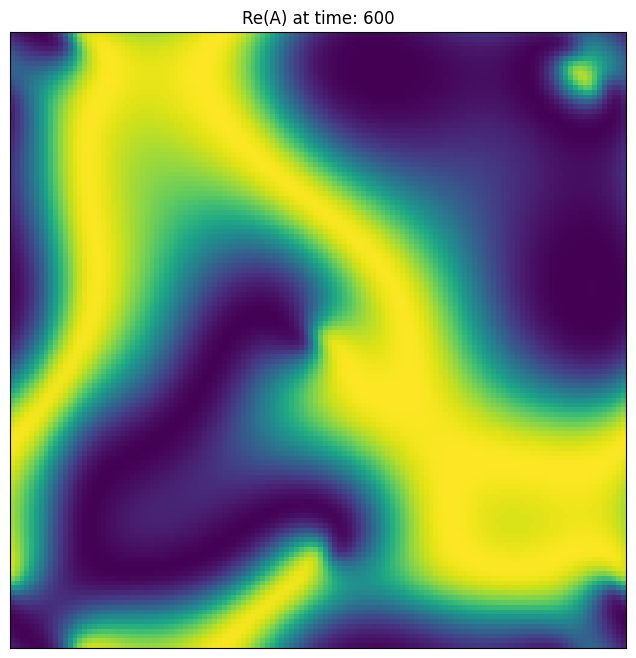

In [27]:
for time_idx in [0, 200, 400, 600]:
    obs_x, obs_y = zip(*observation_locations)
    obs_x = np.array(obs_x)
    obs_y = np.array(obs_y)
    
    obs_values = jnp.abs(signal_answer[time_idx, 0, :, :])[obs_x, obs_y]
    noisy_obs = obs_values + np.random.normal(0, observation_noise, size=len(obs_values))
    
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(jnp.abs(signal_answer[time_idx, 0, :, :]), origin='lower', cmap='plasma', alpha=1)
    plt.scatter(obs_y, obs_x, c=noisy_obs, cmap='plasma', s=60, marker='o', label='Noisy Observations', edgecolors='k', alpha=1)
    plt.title(f'|A| and observations at time: {time_idx}')
    plt.legend()
    path = f'/Users/jmw/Documents/GitHub/Particle_Filter/Saving/CGLE/'
    plt.savefig(f'{path}CGLE_obs_t{time_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(jnp.real(signal_answer[time_idx, 0, :, :]), origin='lower', cmap='viridis', alpha=1)
    plt.title(f'Re(A) at time: {time_idx}')
    path = f'/Users/jmw/Documents/GitHub/Particle_Filter/Saving/CGLE/'
    plt.savefig(f'{path}CGLE_real_t{time_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()


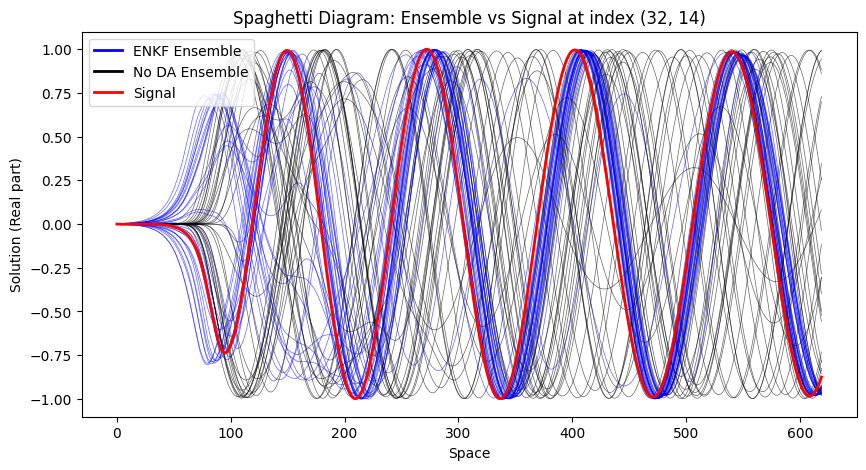

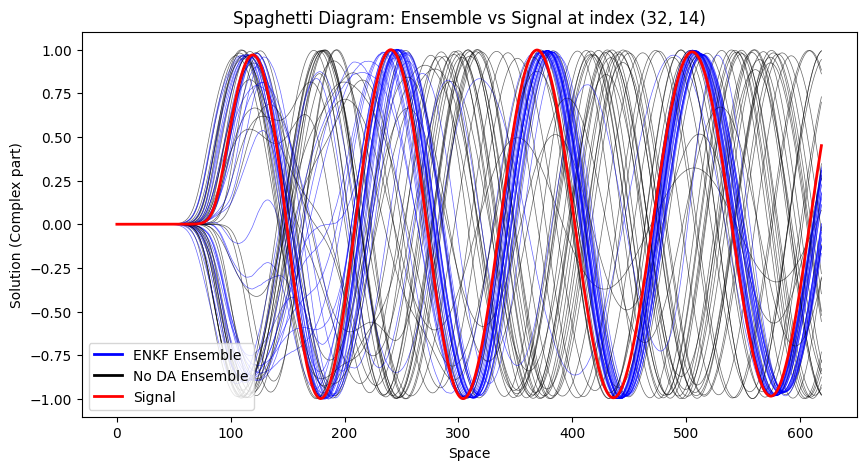

In [28]:
plt.figure(figsize=(10, 5))
# Plot all ensemble members (spaghetti)
k,l = 32,14
tmax = 620
for e in range(answer.shape[1]):
    plt.plot(answer[:tmax, e, k,l].real.T, color='b', alpha=0.6, linewidth=0.5)
    plt.plot(noda_answer[:tmax, e, k,l].imag.T, color='k', alpha=0.6, linewidth=0.5)
# Plot the signal
plt.plot([], color='b', alpha=1, linewidth=2,label='ENKF Ensemble')
plt.plot([], color='k', alpha=1, linewidth=2, label='No DA Ensemble')
plt.plot(signal_answer[:tmax,0,k,l].real.T, color='r', linewidth=2, label='Signal')
plt.xlabel('Space')
plt.ylabel('Solution (Real part)')
plt.title(f'Spaghetti Diagram: Ensemble vs Signal at index {k,l}')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
# Plot all ensemble members (spaghetti)
for e in range(answer.shape[1]):
    plt.plot(answer[:tmax, e, k,l].imag.T, color='b', alpha=0.6, linewidth=0.5)
    plt.plot(noda_answer[:tmax, e, k,l].imag.T, color='k', alpha=0.6, linewidth=0.5)
# Plot the signal
plt.plot([], color='b', alpha=1, linewidth=2,label='ENKF Ensemble')
plt.plot([], color='k', alpha=1, linewidth=2, label='No DA Ensemble')
plt.plot(signal_answer[:tmax,0,k,l].imag.T, color='r', linewidth=2, label='Signal')
plt.xlabel('Space')
plt.ylabel('Solution (Complex part)')
plt.title(f'Spaghetti Diagram: Ensemble vs Signal at index {k,l}')
plt.legend()
plt.show()

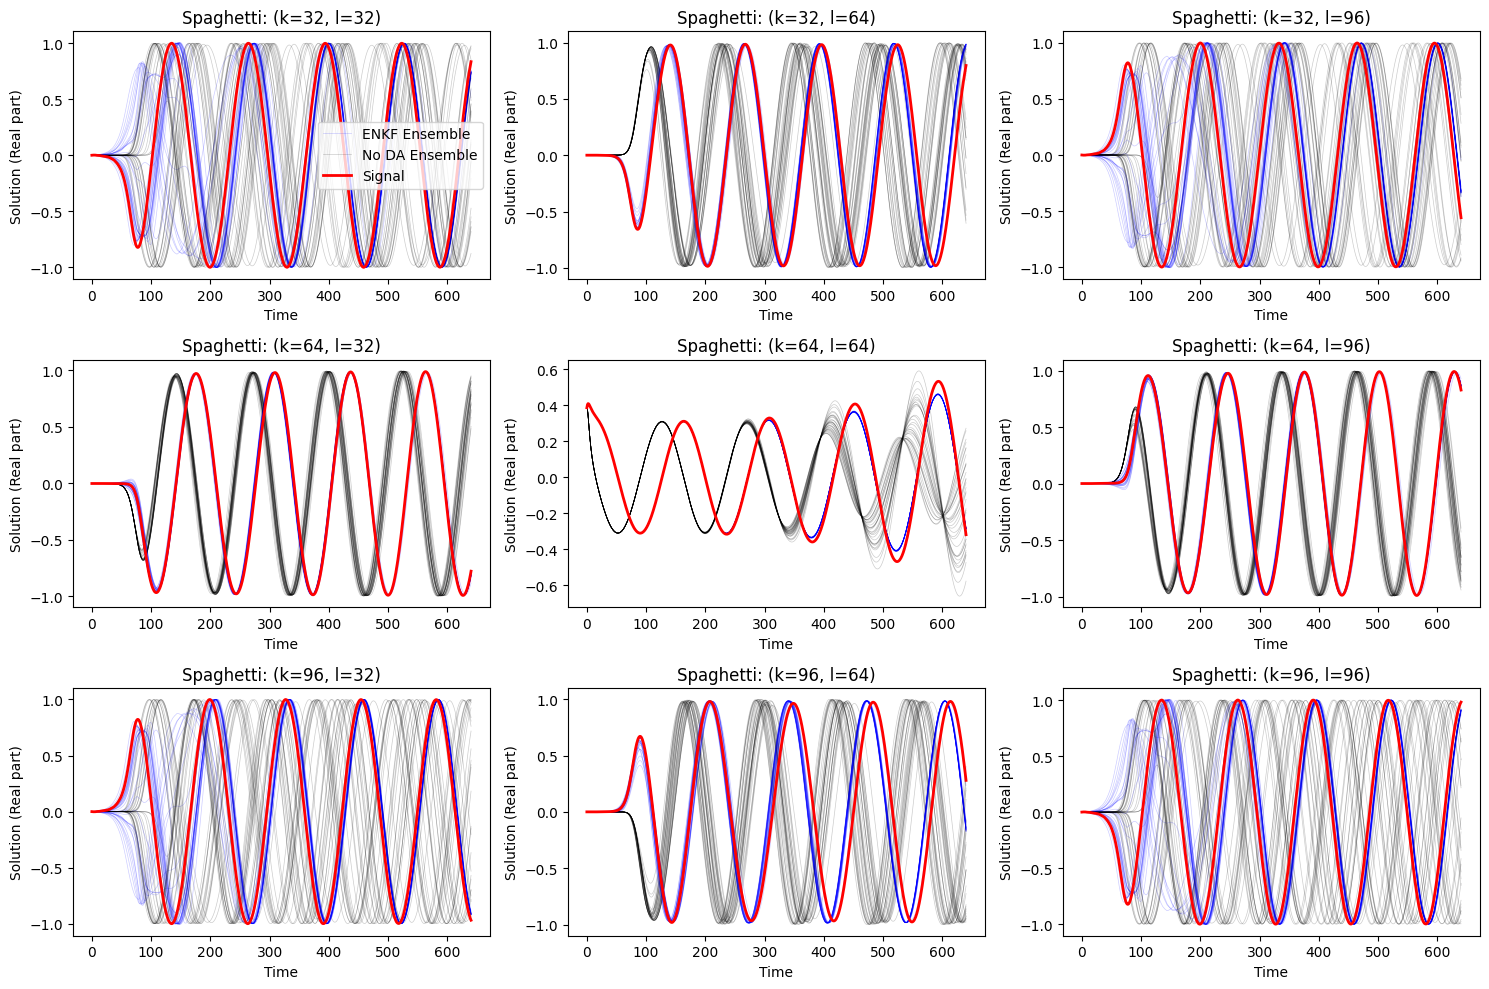

In [29]:
plt.figure(figsize=(15, 10))
points = [(32, 32), (32, 64), (32, 96), ( 64, 32), ( 64, 64), ( 64, 96), (96, 32), (96, 64), (96, 96)]  # 9 example points
tmax= 5620
for idx, (k, l) in enumerate(points):
    plt.subplot(3, 3, idx + 1)
    for e in range(answer.shape[1]):
        plt.plot(answer[:tmax, e, k, l].real.T, color='b', alpha=0.2, linewidth=0.5)
        plt.plot(noda_answer[:tmax, e, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5)
    plt.plot(answer[:tmax, 0, k, l].real.T, color='b', alpha=0.2, linewidth=0.5, label='ENKF Ensemble')
    plt.plot(noda_answer[:tmax, 0, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5, label='No DA Ensemble')
    plt.plot(signal_answer[:tmax, 0, k, l].real.T, color='r', linewidth=2, label='Signal')
    plt.xlabel('Time')
    plt.ylabel('Solution (Real part)')
    plt.title(f'Spaghetti: (k={k}, l={l})')
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

when sigma small, we observe that the repeated use of ENKF, stops the spread from growing and the forecast is highly sharp, this probably leads to overconfident forecasts in general but is useful in other tasks. 

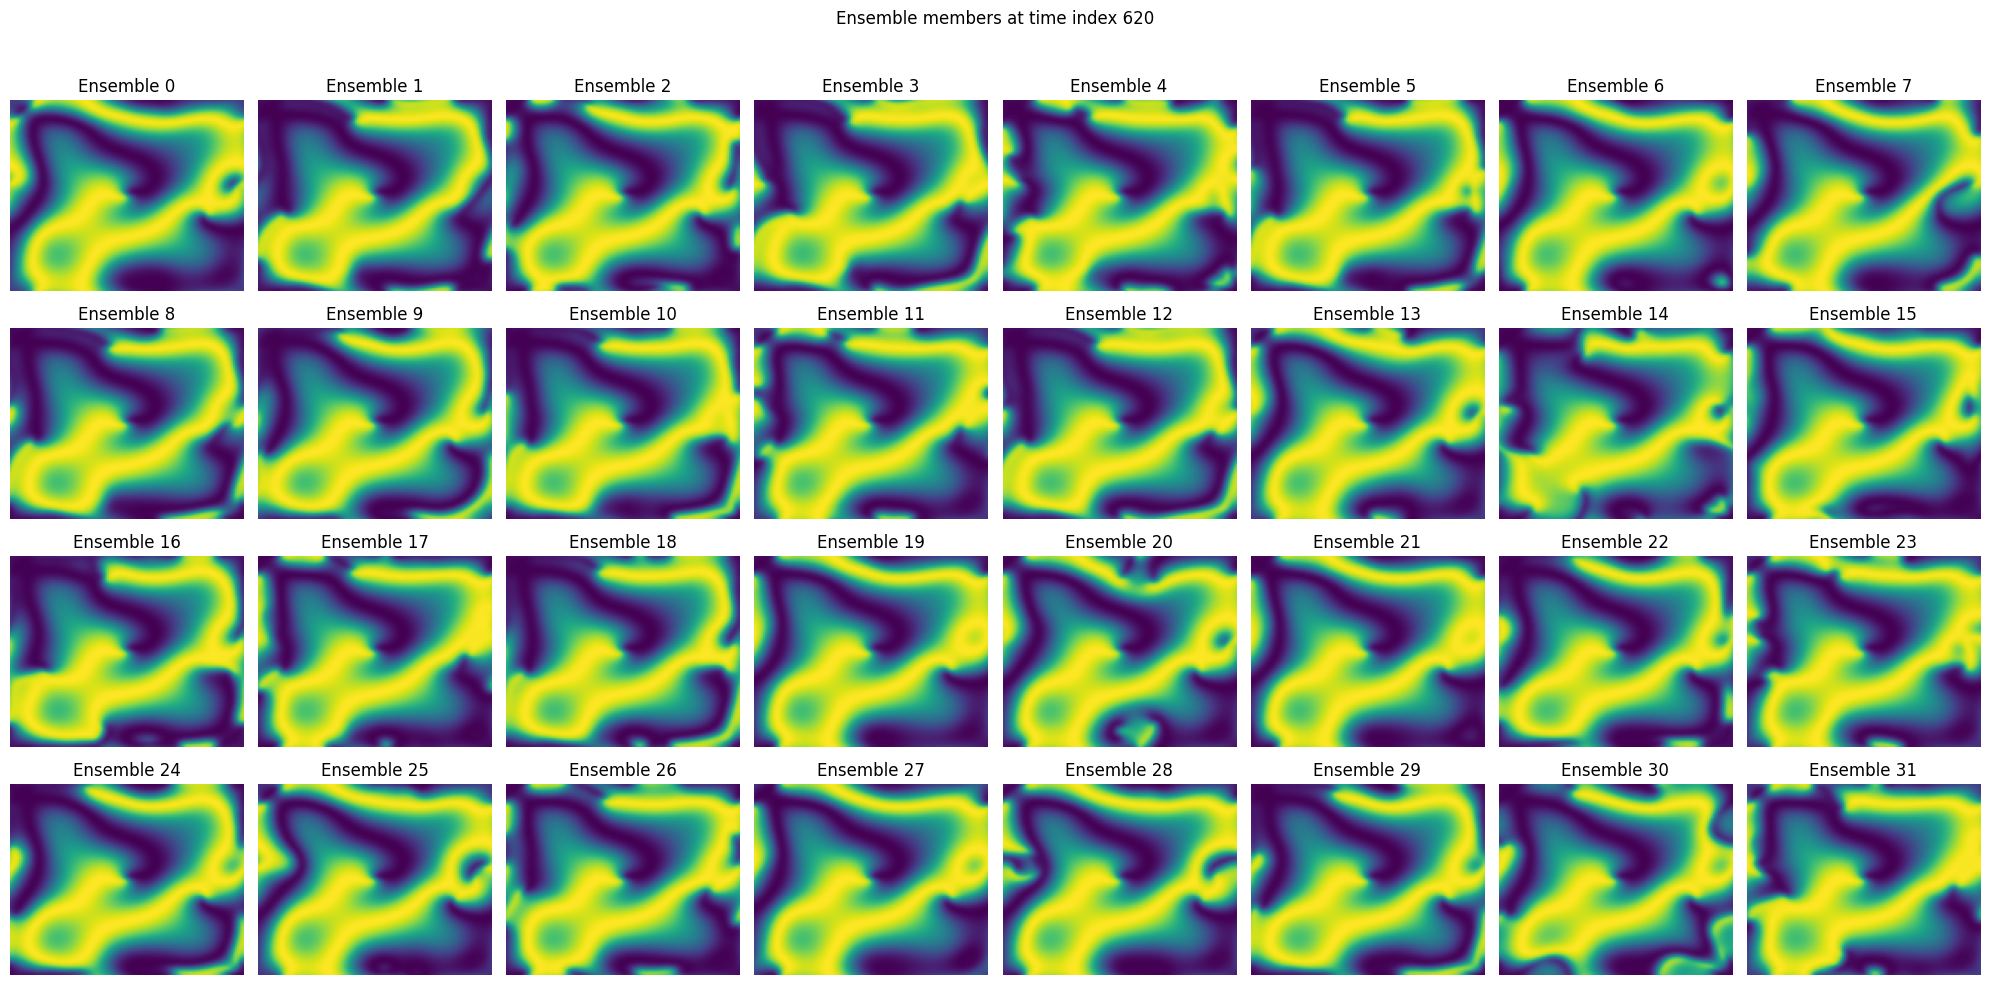

In [30]:
time_idx = 620  # choose the time index you want to visualize
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(answer[time_idx, i, :, :].real.T, aspect='auto')
    plt.title(f'Ensemble {i}')
    plt.axis('off')
plt.suptitle(f'Ensemble members at time index {time_idx}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

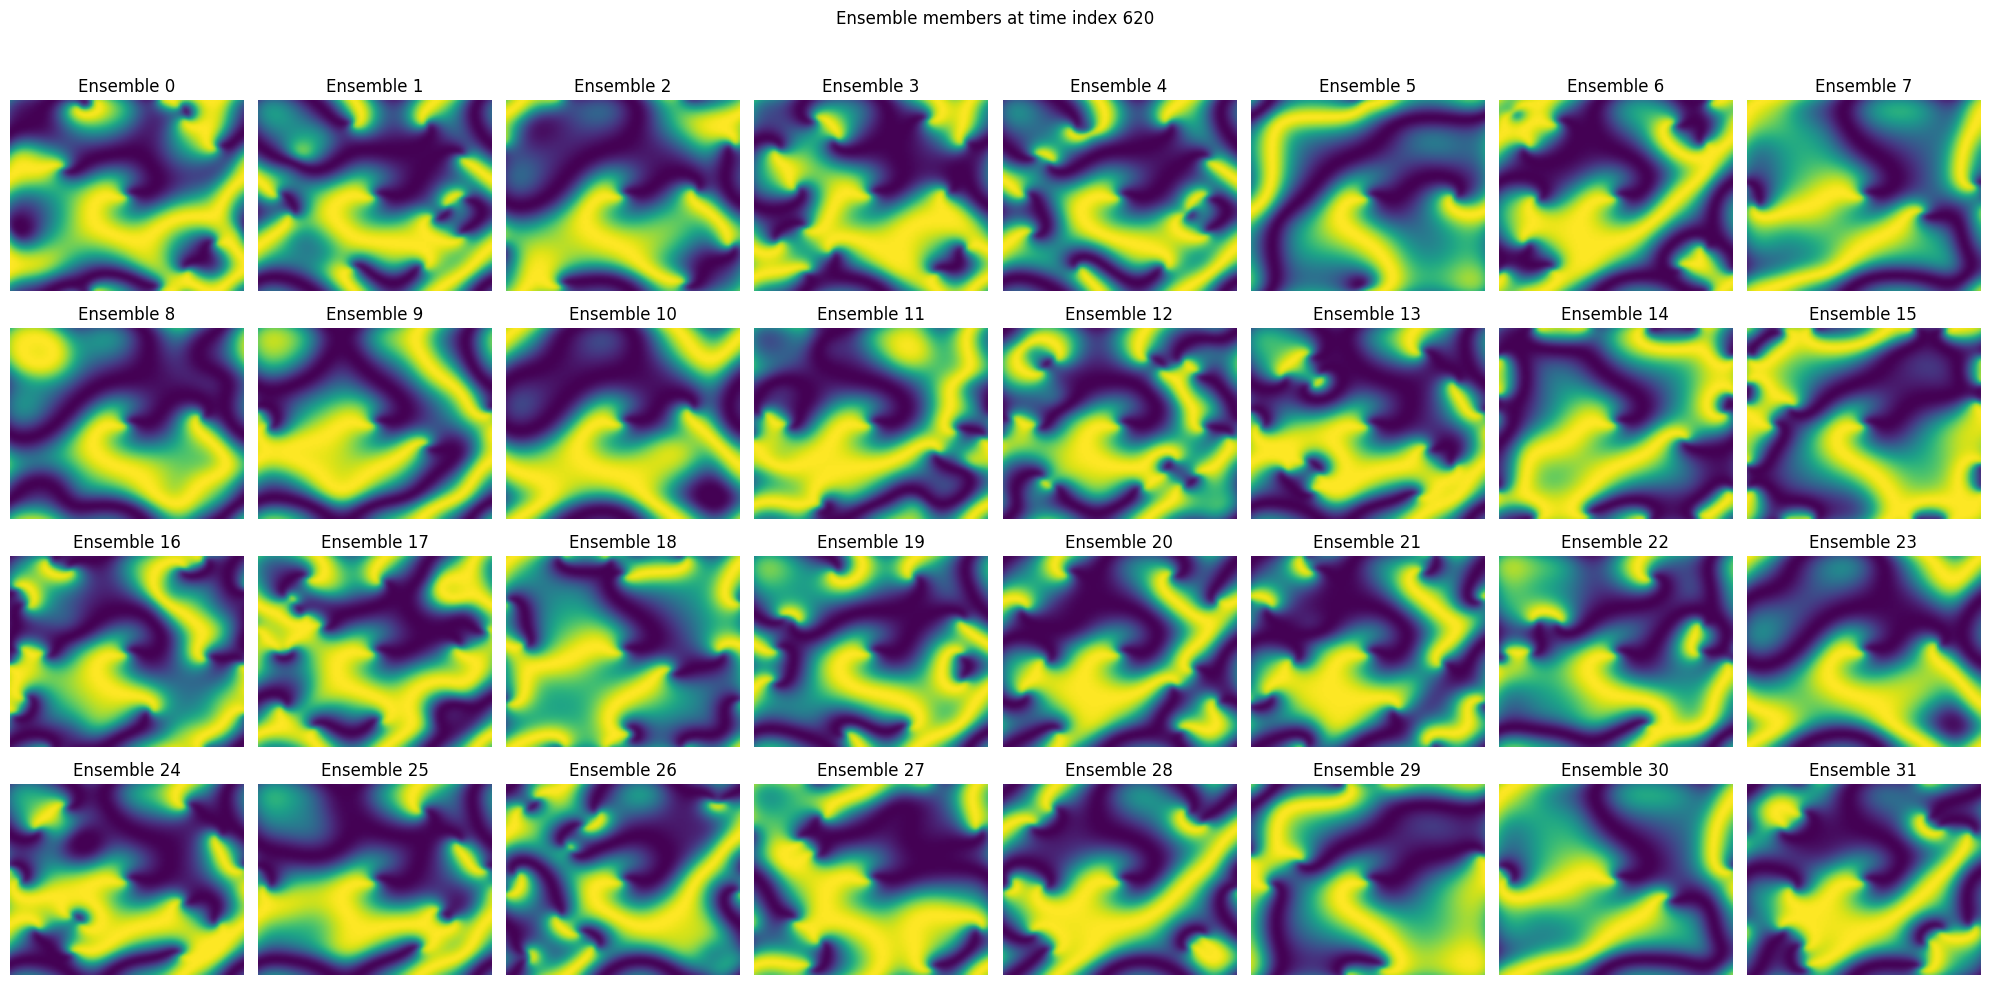

In [31]:
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(noda_answer[time_idx, i, :, :].real.T, aspect='auto')
    plt.title(f'Ensemble {i}')
    plt.axis('off')
plt.suptitle(f'Ensemble members at time index {time_idx}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

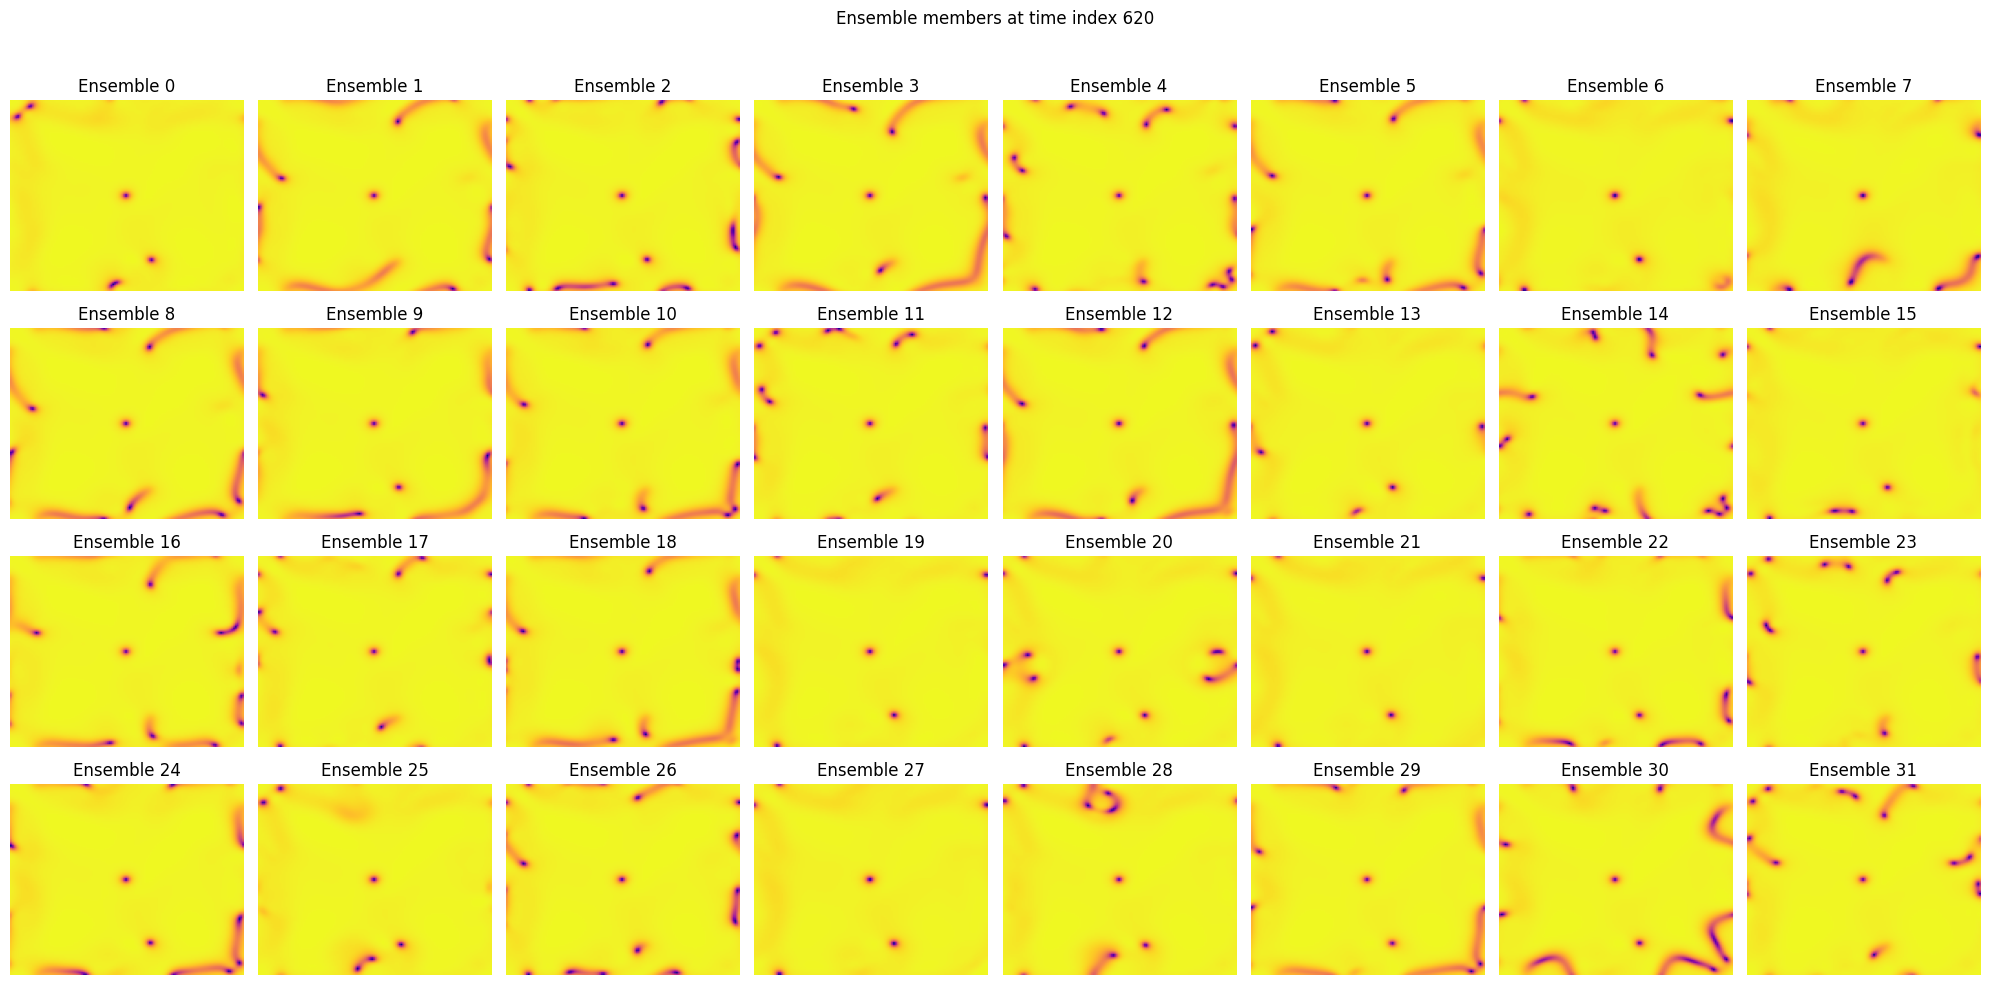

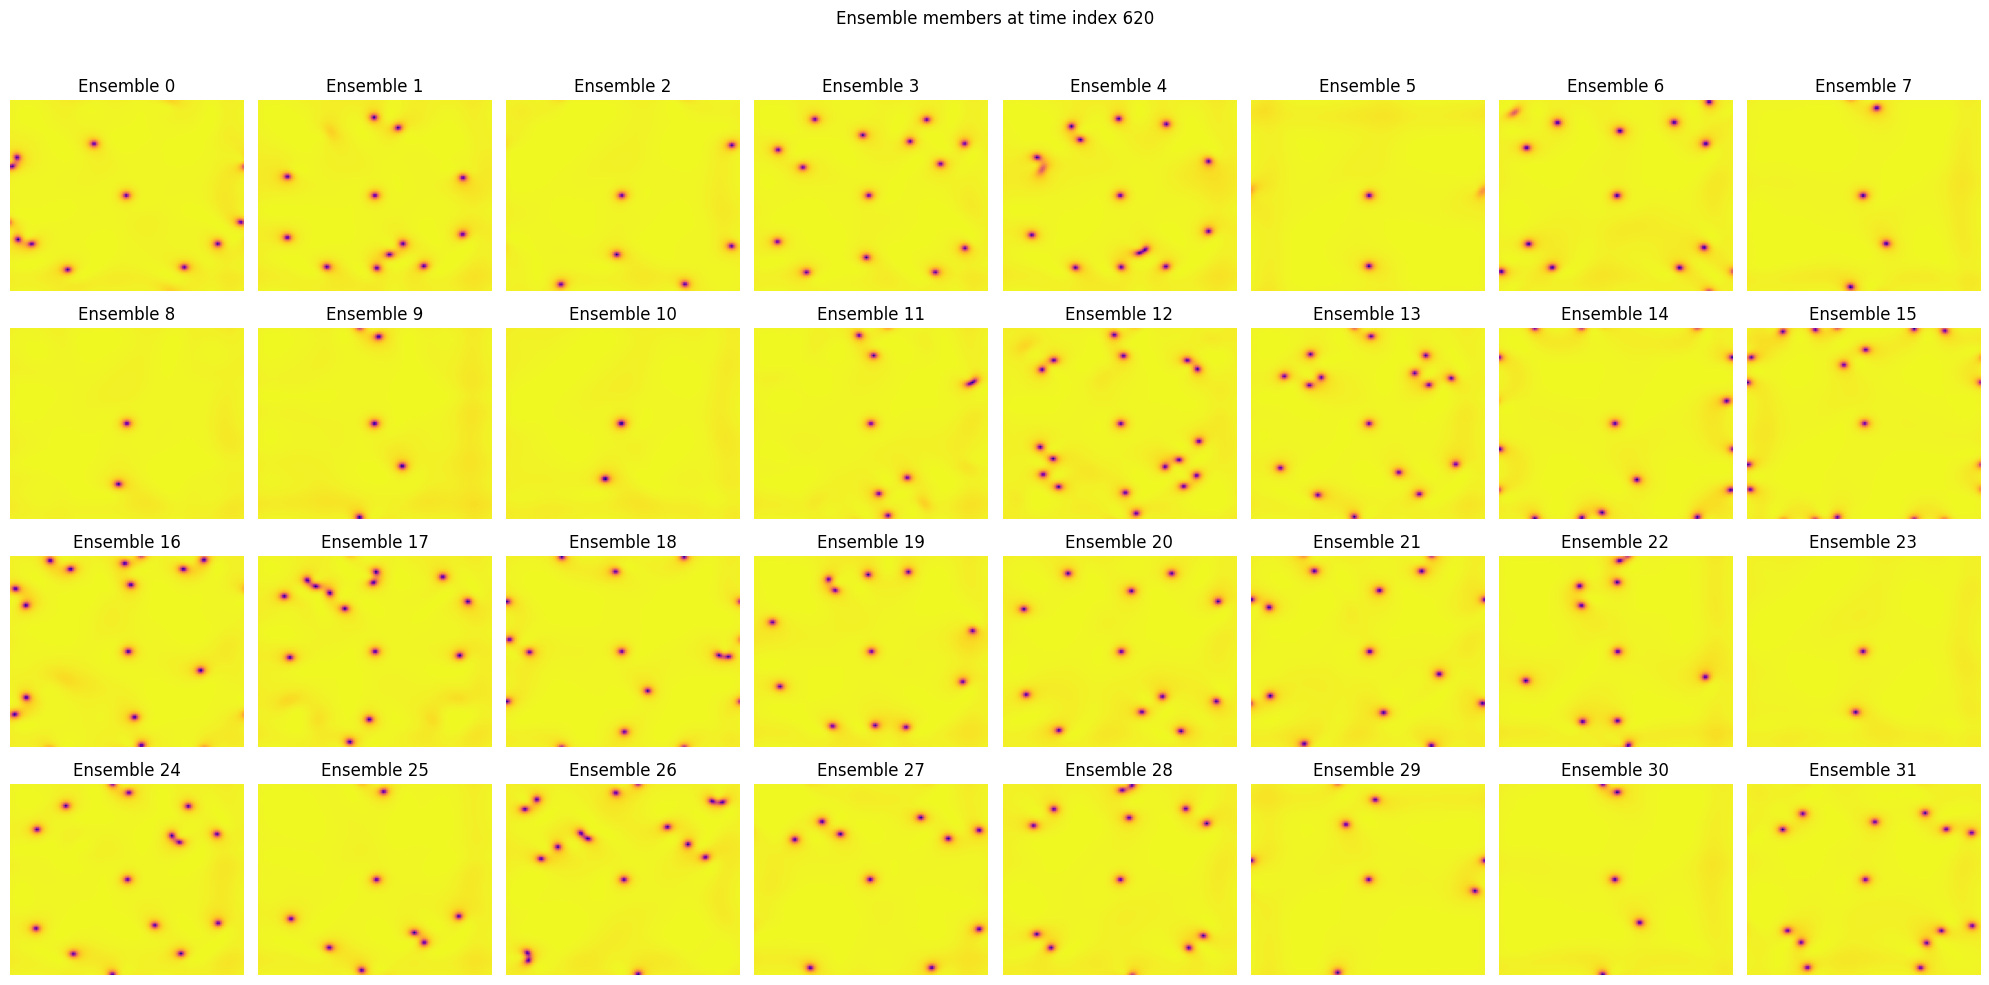

In [32]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(jnp.abs(answer[time_idx, i, :, :]), aspect='auto',cmap='plasma')
    plt.title(f'Ensemble {i}')
    plt.axis('off')
plt.suptitle(f'Ensemble members at time index {time_idx}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(jnp.abs(noda_answer[time_idx, i, :, :]), aspect='auto',cmap='plasma')
    plt.title(f'Ensemble {i}')
    plt.axis('off')
plt.suptitle(f'Ensemble members at time index {time_idx}')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [33]:
from JAX_CRPS import jax_crps
print(signal_answer.shape,answer.shape)
crps_values = jax_crps(jnp.real(signal_answer[:,0,:,:]), jnp.real(answer),ensemble_axis=1)
crps_values_no_da = jax_crps(jnp.real(signal_answer[:,0,:,:]), jnp.real(noda_answer),ensemble_axis=1)

mean_crps = jnp.mean(crps_values,axis=(1,2))
mean_crps_no_da = jnp.mean(crps_values_no_da,axis=(1,2))


(641, 1, 128, 128) (641, 32, 128, 128)


In [34]:
rmse = jnp.sqrt( jnp.mean( (jnp.real(answer) - jnp.real(signal_answer))**2, axis=1 ) )
rmse_no_da = jnp.sqrt( jnp.mean( (jnp.real(noda_answer) - jnp.real(signal_answer))**2, axis=1 ) )
print(rmse.shape,rmse_no_da.shape)
mean_rmse = jnp.mean(rmse,axis=(1,2))
mean_rmse_no_da = jnp.mean(rmse_no_da,axis=(1,2))

(641, 128, 128) (641, 128, 128)


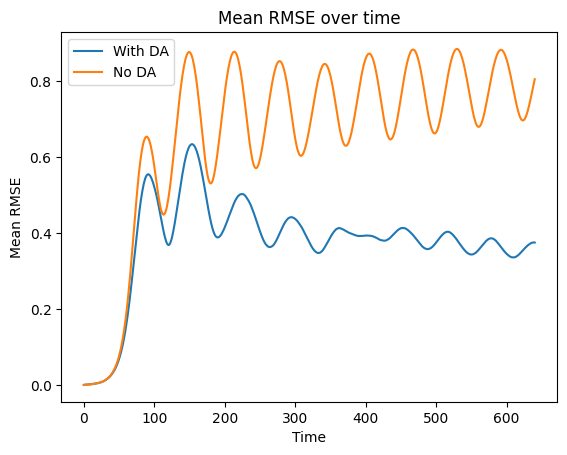

In [35]:
plt.plot(mean_rmse,label='With DA')
plt.plot(mean_rmse_no_da,label='No DA')
plt.xlabel('Time')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE over time')
plt.legend()
plt.show()

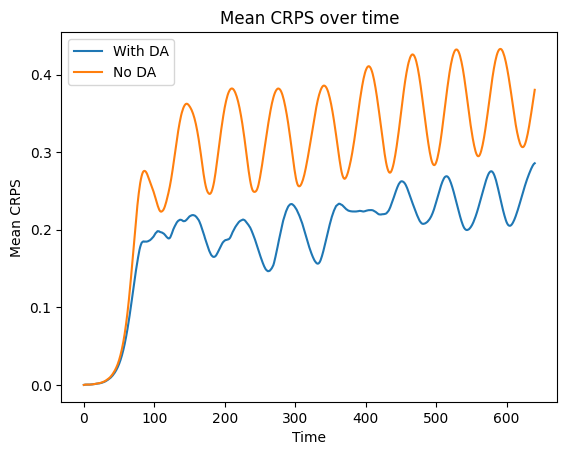

In [36]:
plt.plot(mean_crps,label='With DA')
plt.plot(mean_crps_no_da,label='No DA')
plt.xlabel('Time')
plt.ylabel('Mean CRPS')
plt.title('Mean CRPS over time')
plt.legend()
plt.show()